In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ARR-B"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn064521,MKGKNVIQYFPLTASSSFLIHIDGVITTLGRTQPEIRLTQGTQEAS...,611,1
1,Achn066061,MTVEEIRGRLGGETDRFPVVTSTSQAKTALRMLRENQNRFDLVISD...,445,1
2,Achn096741,MASNKSTRVIFVNFTIEVEREYGSEIERIALSRVKPLRSEFLVYFA...,711,1
3,Achn099501,METGFSSPRTDAFPAGLRVLVVDDDLAWLRILEKMLKKCSYEVTTC...,592,1
4,Achn103181,MNFGVQGEKSMSMPSSSASWKCGDGVSDHFPVGLRVLVVDDDPTCL...,685,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
703,0.001771,0.002657,0.001771,0.009743,0.001771,0.003543,0.000000,0.001771,0.000886,0.002657,...,0.001771,0.000886,0.001771,0.000886,0.000000,0.000886,0.002657,0.0,0.0,0.001771
3990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004367,0.004367,...,0.004367,0.000000,0.000000,0.004367,0.004367,0.000000,0.004367,0.0,0.0,0.000000
4244,0.012174,0.000000,0.005217,0.003478,0.000000,0.000000,0.001739,0.005217,0.001739,0.008696,...,0.005217,0.000000,0.000000,0.001739,0.000000,0.000000,0.000000,0.0,0.0,0.001739
4127,0.056738,0.000000,0.007092,0.003546,0.003546,0.010638,0.000000,0.003546,0.000000,0.007092,...,0.000000,0.003546,0.007092,0.003546,0.000000,0.000000,0.000000,0.0,0.0,0.010638
3205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009615,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3741, 441)
X_test: (936, 441)
y_train: (3741,)
y_test: (936,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 29s 637ms/step - accuracy: 0.4844 - loss: 0.6932

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6802 - loss: 0.6873   

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7472 - loss: 0.6645 - val_accuracy: 0.9640 - val_loss: 0.2975


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.3012

27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 0.2064 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.1730 - val_accuracy: 0.9413 - val_loss: 0.1718


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1062

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1079 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9630 - loss: 0.0946 - val_accuracy: 0.9733 - val_loss: 0.0741


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0351

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0411 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0445 - val_accuracy: 0.9786 - val_loss: 0.0604


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1015

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0312 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9902 - loss: 0.0324 - val_accuracy: 0.9826 - val_loss: 0.0561


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0182

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0170 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0187 - val_accuracy: 0.9693 - val_loss: 0.0796


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0858

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0354 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0283 - val_accuracy: 0.9760 - val_loss: 0.0575


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0056

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0191 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0173 - val_accuracy: 0.9853 - val_loss: 0.0471


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0029

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0044 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0063 - val_accuracy: 0.9840 - val_loss: 0.0475


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0029

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0071 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0094 - val_accuracy: 0.9840 - val_loss: 0.0565


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0037

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0135 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0112 - val_accuracy: 0.9840 - val_loss: 0.0581


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.7983e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0128     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0115 - val_accuracy: 0.9826 - val_loss: 0.0604


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0105

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0032 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9773 - val_loss: 0.0754


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0032

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0095 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0105 - val_accuracy: 0.9866 - val_loss: 0.0590


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0023

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0039 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9826 - val_loss: 0.0631


Epoch 16/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0070 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0063 - val_accuracy: 0.9840 - val_loss: 0.0598


Epoch 17/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.2873e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0023     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9866 - val_loss: 0.0537


Epoch 18/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0020 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9880 - val_loss: 0.0547


Epoch 19/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.9590e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0027     

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0025

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0025 - val_accuracy: 0.9853 - val_loss: 0.0625


Epoch 20/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 5.7087e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010     

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.3263e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1048e-04 - val_accuracy: 0.9866 - val_loss: 0.0597


Epoch 21/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.3550e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.6892e-04 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.7948e-04 - val_accuracy: 0.9880 - val_loss: 0.0624


Epoch 22/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.1473e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.5411e-04 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7153e-04 - val_accuracy: 0.9866 - val_loss: 0.0628


Epoch 23/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.4365e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.7920e-04 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6107e-04 - val_accuracy: 0.9866 - val_loss: 0.0639


Epoch 24/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.8310e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6294e-04 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.7166e-04 - val_accuracy: 0.9866 - val_loss: 0.0700


Epoch 25/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.4597e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0016     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0014 - val_accuracy: 0.9840 - val_loss: 0.0697


Epoch 26/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.1684e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0013     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0151 - val_accuracy: 0.9826 - val_loss: 0.0680


Epoch 27/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0015

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0192 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0146 - val_accuracy: 0.9813 - val_loss: 0.0718


Epoch 28/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.4741e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0018     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9813 - val_loss: 0.0757



[Train Accuracy: 99.93% - Test Accuracy: 98.50%]


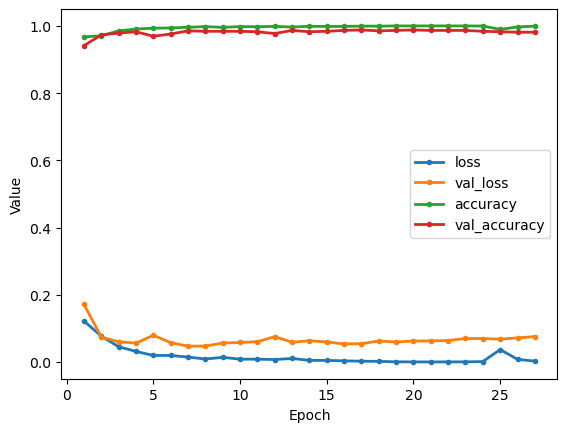

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
703,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000887,...,0.0,0.0,0.000000,0.000000,0.0,0.000887,0.000887,0.0,0.0,0.000000
3990,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
4244,0.003484,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.001742,0.0,0.001742,...,0.0,0.0,0.000000,0.001742,0.0,0.000000,0.000000,0.0,0.0,0.000000
4127,0.028470,0.0,0.0,0.003559,0.003559,0.003559,0.0,0.000000,0.0,0.003559,...,0.0,0.0,0.003559,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.003559
3205,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3741, 8707)
X_test: (936, 8707)
y_train: (3741,)
y_test: (936,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,513 (8.67 MB)

 Trainable params: 2,272,513 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 29s 635ms/step - accuracy: 0.4688 - loss: 0.6932

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4929 - loss: 0.6930   

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4962 - loss: 0.6927

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5011 - loss: 0.6917

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5170 - loss: 0.6900

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5402 - loss: 0.6865

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5633 - loss: 0.6802

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5660 - loss: 0.6793 - val_accuracy: 0.9439 - val_loss: 0.3922


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9688 - loss: 0.3965

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9409 - loss: 0.3632 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9470 - loss: 0.3242

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.2885

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9579 - loss: 0.2590

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9616 - loss: 0.2356

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9645 - loss: 0.2164 - val_accuracy: 0.9960 - val_loss: 0.0171


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0080

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0058 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0054

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0053

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0053

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0052

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9997 - loss: 0.0051 - val_accuracy: 0.9973 - val_loss: 0.0084


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 9.1845e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011     

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9960 - val_loss: 0.0085


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0011

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0034 

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0030

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0028

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9973 - val_loss: 0.0082


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0039

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016 

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5644e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2815e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4507e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8723e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.8101e-04 - val_accuracy: 0.9973 - val_loss: 0.0059


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.8523e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5468e-04 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6356e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5616e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5175e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5031e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5412e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5485e-04 - val_accuracy: 0.9973 - val_loss: 0.0073


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7352e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7604e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9857e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8642e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7623e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6661e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5874e-04 - val_accuracy: 0.9973 - val_loss: 0.0066


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0025

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7171e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6299e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3107e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5679e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1188e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8186e-04 - val_accuracy: 0.9973 - val_loss: 0.0090


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.8863e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6575e-04 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9615e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9479e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9042e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8325e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7675e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.7611e-04 - val_accuracy: 0.9987 - val_loss: 0.0055


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.4692e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014     

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4318e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0981e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1501e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4425e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3669e-04 - val_accuracy: 0.9987 - val_loss: 0.0059


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.0929e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3915e-05 

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6964e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0647e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1425e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1639e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1655e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1633e-04 - val_accuracy: 0.9973 - val_loss: 0.0097


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.5585e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4723e-05 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1768e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7842e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1072e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1719e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.1247e-05 - val_accuracy: 0.9987 - val_loss: 0.0060


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.5636e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0844e-05 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7033e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2310e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8961e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3963e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.5890e-05 - val_accuracy: 0.9973 - val_loss: 0.0056


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1801e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9736e-05 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7072e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8729e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1290e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9101e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3476e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3840e-05 - val_accuracy: 0.9973 - val_loss: 0.0134


Epoch 16/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.9499e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0288e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5499e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0673e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1616e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2571e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2973e-04 - val_accuracy: 0.9987 - val_loss: 0.0063


Epoch 17/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1011e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5237e-05 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0227e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8485e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7133e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6232e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5705e-05 - val_accuracy: 0.9987 - val_loss: 0.0065


Epoch 18/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.7054e-06

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0899e-05 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6322e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4203e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3676e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3486e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3498e-05 - val_accuracy: 0.9987 - val_loss: 0.0063


Epoch 19/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.6372e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9322e-05 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5613e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1672e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2819e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2689e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2218e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2065e-05 - val_accuracy: 0.9987 - val_loss: 0.0073


Epoch 20/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.9951e-06

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6600e-05 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6859e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5618e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4240e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3202e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2149e-05 - val_accuracy: 0.9987 - val_loss: 0.0058



[Train Accuracy: 100.00% - Test Accuracy: 99.79%]


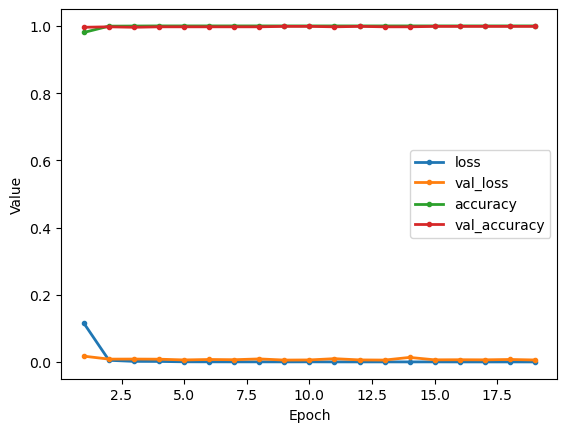

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
703,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3990,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4244,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.001745,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4127,0.017857,0.0,0.0,0.0,0.003571,0.0,0.0,0.000000,0.0,0.003571,...,0.0,0.0,0.0,0.003571,0.0,0.0,0.0,0.0,0.0,0.0
3205,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,352,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,393,473 (138.83 MB)

 Trainable params: 36,393,473 (138.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 39s 849ms/step - accuracy: 0.5000 - loss: 0.6931

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.5000 - loss: 0.6931 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5017 - loss: 0.6931

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5081 - loss: 0.6930

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5096 - loss: 0.6930

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5093 - loss: 0.6929

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5086 - loss: 0.6929

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5085 - loss: 0.6928

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5097 - loss: 0.6927

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5117 - loss: 0.6926

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5139 - loss: 0.6924

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5156 - loss: 0.6922

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5170 - loss: 0.6921

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5179 - loss: 0.6919

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5184 - loss: 0.6917

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5194 - loss: 0.6915

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5205 - loss: 0.6913

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5223 - loss: 0.6911

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5249 - loss: 0.6908

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5282 - loss: 0.6905

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5318 - loss: 0.6902

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5357 - loss: 0.6899

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5400 - loss: 0.6895

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5446 - loss: 0.6892

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5492 - loss: 0.6887

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5540 - loss: 0.6883

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5588 - loss: 0.6878

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5637 - loss: 0.6873

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5685 - loss: 0.6867

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5733 - loss: 0.6861

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5779 - loss: 0.6854

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5826 - loss: 0.6847

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5871 - loss: 0.6839

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5916 - loss: 0.6831

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5960 - loss: 0.6822

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.6004 - loss: 0.6813

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.6046 - loss: 0.6803

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.6088 - loss: 0.6792

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.6130 - loss: 0.6781

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6170 - loss: 0.6769

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6210 - loss: 0.6756

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6248 - loss: 0.6743

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6286 - loss: 0.6729

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6323 - loss: 0.6715

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6359 - loss: 0.6700

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6395 - loss: 0.6684

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6429 - loss: 0.6667

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.6463 - loss: 0.6652 - val_accuracy: 0.9840 - val_loss: 0.2668


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.9844 - loss: 0.2530

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9883 - loss: 0.2485 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9905 - loss: 0.2394

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9909 - loss: 0.2326

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9915 - loss: 0.2272

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9920 - loss: 0.2219

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9922 - loss: 0.2173

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9924 - loss: 0.2127

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9927 - loss: 0.2083

10/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9930 - loss: 0.2041

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9931 - loss: 0.2001

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9929 - loss: 0.1965

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9928 - loss: 0.1929

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9928 - loss: 0.1894

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9927 - loss: 0.1860

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9925 - loss: 0.1828

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9924 - loss: 0.1798

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9924 - loss: 0.1768

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9923 - loss: 0.1739

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9922 - loss: 0.1711

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9922 - loss: 0.1684

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9922 - loss: 0.1658

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9922 - loss: 0.1633

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9922 - loss: 0.1609

25/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9922 - loss: 0.1586

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9922 - loss: 0.1563

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9922 - loss: 0.1541

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9922 - loss: 0.1520

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9922 - loss: 0.1499

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9923 - loss: 0.1479

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9923 - loss: 0.1460

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9923 - loss: 0.1441

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9923 - loss: 0.1423

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9924 - loss: 0.1405

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9924 - loss: 0.1388

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9924 - loss: 0.1372

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9924 - loss: 0.1356

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9924 - loss: 0.1340

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9924 - loss: 0.1325

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9925 - loss: 0.1310

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9925 - loss: 0.1296

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9925 - loss: 0.1281

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9925 - loss: 0.1268

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9925 - loss: 0.1254

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9925 - loss: 0.1242

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9926 - loss: 0.1229

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9926 - loss: 0.1217

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9926 - loss: 0.1205 - val_accuracy: 0.9960 - val_loss: 0.0232


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 1.0000 - loss: 0.0031

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 0.0048 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0051

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0051

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0051

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0050

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0049

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0049

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0048

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0047

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0046

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0045

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0045

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0044

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0044

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0043

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0043

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0042

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0042

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0041

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0041

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0040

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0040

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0040

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0039

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0039

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0039

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0038

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0038

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0038

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0038

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0037

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0037

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0037

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0037

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0036

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0036

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0036

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0036

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0036

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0035

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0035

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0035

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9999 - loss: 0.0035

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9999 - loss: 0.0035

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9999 - loss: 0.0035

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9999 - loss: 0.0034

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.9920 - val_loss: 0.0201


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 1.0000 - loss: 0.0021

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0019

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0017

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0016

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0015

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0015

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0015

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0014

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0014

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0014

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0014

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0014

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0014

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0013

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0013

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0013

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0012

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0012

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0012

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0012

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0012

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0012

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0012

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0012

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0012

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0012

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9933 - val_loss: 0.0145


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 1.0000 - loss: 4.6386e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.4378e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.6372e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.6696e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.7442e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 4.8810e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.9630e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 4.9984e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.0292e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.1300e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.2109e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.2654e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.3156e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.3591e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.3847e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.3965e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.3987e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.4235e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.4427e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.4542e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.4681e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4758e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4838e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4873e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4882e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4913e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4945e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.4983e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5005e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.5021e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5017e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.5001e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 5.4966e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 5.4914e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.4849e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.4783e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.4779e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.4818e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4837e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4833e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4830e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4841e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4839e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4827e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.4799e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.4766e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.4727e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.4690e-04 - val_accuracy: 0.9947 - val_loss: 0.0134


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 1.0000 - loss: 6.5876e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3501e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.9286e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.5939e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.4228e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.3750e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.2795e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.2012e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.1273e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0519e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.9743e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.8957e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.8279e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.7705e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.7125e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.6519e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.6069e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5669e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5339e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.5003e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.4655e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.4327e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.4021e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3716e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3423e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3123e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2856e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2623e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2392e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2188e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1990e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1799e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1609e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1427e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1257e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1086e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0926e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0765e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0614e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.0464e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.0313e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.0161e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.0006e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9852e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9726e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9601e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9477e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.9358e-04 - val_accuracy: 0.9920 - val_loss: 0.0150


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.3635e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.0594e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.9193e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8499e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.8698e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.9389e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.9801e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.0039e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0517e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.0826e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.1014e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.1126e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.1153e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.1196e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.1243e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1297e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1422e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1507e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1555e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1578e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1585e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1579e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1577e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1564e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1574e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1578e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1574e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1562e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1547e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1537e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1527e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1527e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1618e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1695e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1772e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.1844e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1912e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1976e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.2036e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2092e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2144e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2185e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2221e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2249e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2271e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2311e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.2345e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.2378e-04 - val_accuracy: 0.9933 - val_loss: 0.0137


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.6205e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.5223e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.5649e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.6830e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.7633e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7880e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.8126e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8184e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.8167e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.8103e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.8005e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7959e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.7875e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7781e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7660e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7540e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7420e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7320e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7267e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7208e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7144e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.7068e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7058e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7084e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.7099e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.7103e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.7108e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.7103e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.7090e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.7072e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7068e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7055e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7041e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.7034e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7023e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7013e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.6996e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.6980e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.6962e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6940e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6916e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6888e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6857e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6822e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6784e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6749e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.6718e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.6688e-04 - val_accuracy: 0.9933 - val_loss: 0.0142


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 4.0172e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 5.9967e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.4227e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 7.1741e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.7217e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 8.0440e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 8.1818e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.4757e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 8.7066e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 9.0228e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 9.2501e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 9.4196e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 9.7995e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.0096e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.0322e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.0516e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.0679e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.0811e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0921e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1012e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1097e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1157e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1217e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1268e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1308e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1335e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1352e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1361e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1368e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1372e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.1375e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1376e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1370e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1360e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1349e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1338e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1326e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1310e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.1293e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1274e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1255e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1237e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1216e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1193e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1172e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1151e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.1164e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.1176e-04 - val_accuracy: 0.9920 - val_loss: 0.0148


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.3832e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.1717e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0888e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.0195e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 9.7119e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 9.2532e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 9.1037e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 8.9425e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.7609e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.5975e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.4729e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 8.3457e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.2288e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.1554e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.1158e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.0801e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.0487e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 8.0199e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 7.9935e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 7.9651e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 7.9293e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 7.8962e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 7.8628e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.8293e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7915e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7553e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7288e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7002e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.6719e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.6495e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.6277e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.6081e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.5870e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.5811e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.5721e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.5611e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.5513e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.5413e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.5316e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.5224e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.5124e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.5035e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.5007e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.4971e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.4933e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.4909e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.4941e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.4972e-05 - val_accuracy: 0.9920 - val_loss: 0.0159


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.2120e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.0147e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 9.0321e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 8.4206e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.0073e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.8592e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.7563e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.6199e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 7.4811e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 7.4930e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 7.4666e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 7.4242e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 7.3749e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.3132e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.2654e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.2181e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.1897e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.1576e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.1290e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.0952e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.0536e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.0135e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.9937e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.9725e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.9923e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.0039e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.0114e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.0138e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.0139e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.0084e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.0000e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9898e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9774e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9707e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9627e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9534e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9443e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9338e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.9227e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.9139e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.9038e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.8926e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.8825e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.8725e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.8651e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.8581e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.8510e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 6.8443e-05 - val_accuracy: 0.9947 - val_loss: 0.0127


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 1.0000 - loss: 3.3503e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.4501e-05 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.7343e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.9159e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.9794e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.0122e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.0856e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 4.1332e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.1802e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.2125e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.2364e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.2513e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.2560e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.2912e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3130e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3491e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 4.3709e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.3869e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 4.4016e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.4193e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.4323e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 4.4427e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 4.4518e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 4.4562e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.4557e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.4586e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.4575e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.4536e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.4477e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 4.4406e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 4.4341e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4322e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4281e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4226e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4244e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4253e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4256e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4247e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 4.4239e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.4238e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.4225e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 4.4197e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 4.4233e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 4.4258e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.4275e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.4308e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.4334e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 4.4360e-05 - val_accuracy: 0.9920 - val_loss: 0.0158



[Train Accuracy: 100.00% - Test Accuracy: 98.93%]


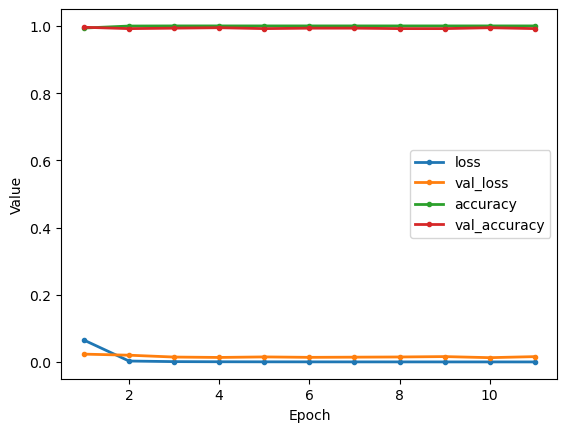

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

10/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

15/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

13/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/ARR-B/report_9RRFTPP9.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################